# Stack-Overflow Annual Developer Survey Analyis


Within this Analysis I analyze what influences Salary within developer jobs.

In [1]:
# Import all packages needed
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt


In [ ]:
# Load survey schema

schema = pd.read_csv('data/survey_results_schema.csv')
schema.head()

,qid,qname,question,force_resp,type,selector
0,QID2,MainBranch,Which of the following options best describes ...,True,MC,SAVR
1,QID127,Age,What is your age?*,True,MC,SAVR
2,QID296,Employment,Which of the following best describes your cur...,True,MC,MAVR
3,QID308,RemoteWork,Which best describes your current work situation?,False,MC,SAVR
4,QID341,Check,Just checking to make sure you are paying atte...,True,MC,SAVR


In [ ]:
# Load data

df = pd.read_csv('data/survey_results_public.csv')
df.head()

,ResponseId,MainBranch,Age,Employment,RemoteWork,Check,CodingActivities,EdLevel,LearnCode,LearnCodeOnline,...,JobSatPoints_6,JobSatPoints_7,JobSatPoints_8,JobSatPoints_9,JobSatPoints_10,JobSatPoints_11,SurveyLength,SurveyEase,ConvertedCompYearly,JobSat
0,1,I am a developer by profession,Under 18 years old,"Employed, full-time",Remote,Apples,Hobby,Primary/elementary school,Books / Physical media,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,I am a developer by profession,35-44 years old,"Employed, full-time",Remote,Apples,Hobby;Contribute to open-source projects;Other...,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Books / Physical media;Colleague;On the job tr...,Technical documentation;Blogs;Books;Written Tu...,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
2,3,I am a developer by profession,45-54 years old,"Employed, full-time",Remote,Apples,Hobby;Contribute to open-source projects;Other...,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",Books / Physical media;Colleague;On the job tr...,Technical documentation;Blogs;Books;Written Tu...,...,NaN,NaN,NaN,NaN,NaN,NaN,Appropriate in length,Easy,NaN,NaN
3,4,I am learning to code,18-24 years old,"Student, full-time",NaN,Apples,NaN,Some college/university study without earning ...,"Other online resources (e.g., videos, blogs, f...",Stack Overflow;How-to videos;Interactive tutorial,...,NaN,NaN,NaN,NaN,NaN,NaN,Too long,Easy,NaN,NaN
4,5,I am a developer by profession,18-24 years old,"Student, full-time",NaN,Apples,NaN,"Secondary school (e.g. American high school, G...","Other online resources (e.g., videos, blogs, f...",Technical documentation;Blogs;Written Tutorial...,...,NaN,NaN,NaN,NaN,NaN,NaN,Too short,Easy,NaN,NaN


## Exploratory Data Analysis

Check the PDF of the Survey that comes with the data for a detailed understanding of the survey and its questions (i.e. potential features and targets).

#### Check the target = Salary

In [42]:
# some simple descriptive statistics
print(f'Rows without salary information {df.ConvertedCompYearly.isna().sum()}')
df.ConvertedCompYearly.describe()

Rows without salary information 42002


count    2.343500e+04
mean     8.615529e+04
std      1.867570e+05
min      1.000000e+00
25%      3.271200e+04
50%      6.500000e+04
75%      1.079715e+05
max      1.625660e+07
Name: ConvertedCompYearly, dtype: float64

Text(0.5, 1.0, 'Historgram over Salary (< 200k)')

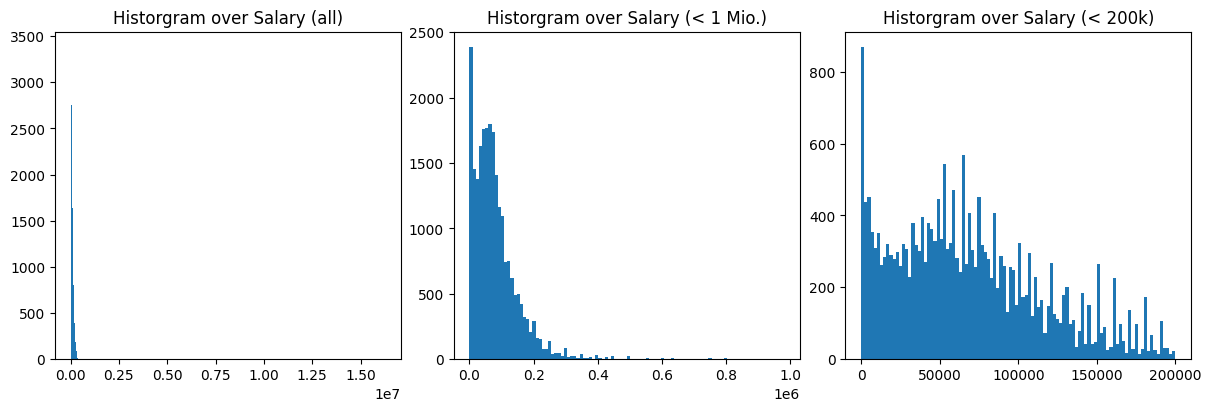

In [ ]:
# Check distribution of salary

fig, axs = plt.subplots(1, 3, layout='constrained', figsize=(12, 4))
axs[0].hist(df.ConvertedCompYearly, bins = 1000) 
axs[0].set_title('Historgram over Salary (all)')
axs[1].hist(df.ConvertedCompYearly[df.ConvertedCompYearly < 1000000], bins = 100) 
axs[1].set_title('Historgram over Salary (< 1 Mio.)')
axs[2].hist(df.ConvertedCompYearly[df.ConvertedCompYearly < 200000], bins = 100) 
axs[2].set_title('Historgram over Salary (< 200k)')


*Issues*  to consider:
- Just a little more than 1/3 of the participants gave a salary.
- Salary extremly skewed (potentially influential outliers)
- A lot of participants gave unrealistically small salary (~ 0)


#### Potential features examination

## Model development

## Prediction Scenario